# Data Load

In [1]:
import pandas as pd

data_puskesmas = pd.read_csv("preprocessed-review.csv")
data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id
3,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id
4,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id


In [2]:
train_data = data_puskesmas[
    (data_puskesmas["rating"] == 5) | (data_puskesmas["rating"] == 1)
]
test_data = data_puskesmas[
    (data_puskesmas["rating"] != 5) & (data_puskesmas["rating"] != 1)
]

print("train_data.shape:", train_data.shape)
print("test_data.shape:", test_data.shape)

train_data.shape: (7808, 6)
test_data.shape: (1218, 6)


test data adalah data yang tidak jelas dia tergolong positif atau negatif, sehingga kita perlu melakukan prediksi terhadap data tersebut. Karena data tersebut berkisar antara rating 1-5, maka kita akan menggunakan model klasifikasi untuk memprediksi data tersebut.

In [3]:
# make the rating 5 as 1 and the rating 1 as 0
train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)

print(train_data["is_positive"].value_counts())

is_positive
1    4953
0    2855
Name: count, dtype: int64


/tmp/ipykernel_3523/1439492560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)


In [4]:
from sklearn.model_selection import train_test_split

train_data_resample, val_data = train_test_split(
    train_data, test_size=0.2, random_state=42, stratify=train_data["is_positive"]
)

print("train_data_resample.shape:", train_data_resample.shape)
print("val_data.shape:", val_data.shape)

train_data_resample.shape: (6246, 7)
val_data.shape: (1562, 7)


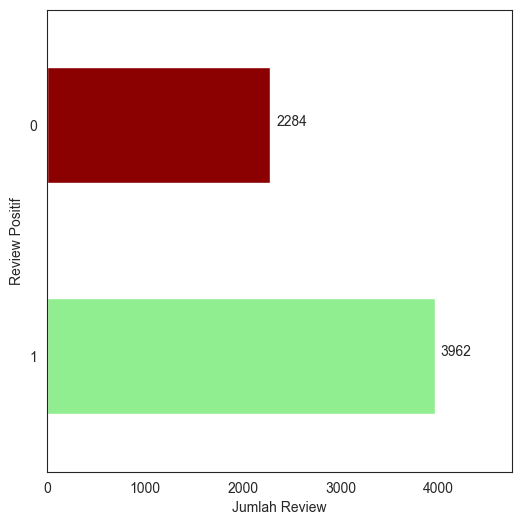

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(
    train_data_resample, train_data_resample["is_positive"]
)

train_data_resample = pd.DataFrame(X_resampled, columns=train_data.columns)

print(train_data_resample["is_positive"].value_counts())

is_positive
0    2284
1    2284
Name: count, dtype: int64


nanti datanya akan dicombine ulang untuk analsis lebih lanjut

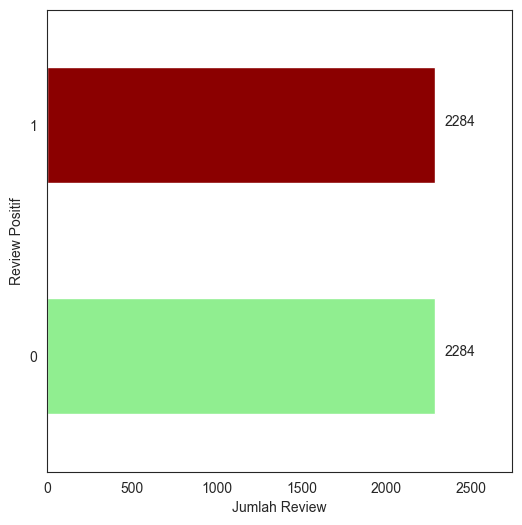

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

# Model Building

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_resample.review_text)

word_idx, vocab_size = tokenizer.word_index, len(tokenizer.word_index) + 1

print("vocab_size:", vocab_size)

2024-06-23 22:06:21.398117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 22:06:23.051523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


vocab_size: 10955


In [9]:
from keras.preprocessing.sequence import pad_sequences

# convert text data to sequences
text_sequences_train = tokenizer.texts_to_sequences(train_data_resample.review_text)
text_sequences_val = tokenizer.texts_to_sequences(val_data.review_text)

# pad the sequences
max_length = max([len(sequence) for sequence in text_sequences_train])

text_sequences_train = pad_sequences(text_sequences_train, maxlen=max_length)
text_sequences_val = pad_sequences(text_sequences_val, maxlen=max_length)

print("text_sequences_train.shape:", text_sequences_train.shape)
print("text_sequences_val.shape:", text_sequences_val.shape)

text_sequences_train.shape: (4568, 585)
text_sequences_val.shape: (1562, 585)


In [10]:
y_train = train_data_resample.is_positive
y_val = val_data.is_positive

print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

y_train.shape: (4568,)
y_val.shape: (1562,)


In [11]:
import numpy as np
from fasttext import FastText
from tqdm.notebook import tqdm

ft = FastText.load_model("cc.id.300.bin")

embedding_matrix = np.zeros((vocab_size, 300))

for word, idx in tqdm(word_idx.items()):
    embedding_vec = ft.get_word_vector(word)
    if embedding_vec is not None:
        embedding_matrix[idx] = embedding_vec

  0%|          | 0/10954 [00:00<?, ?it/s]

In [12]:
import tensorflow as tf

embbeding_layer = tf.keras.layers.Embedding(
    vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False
)

/home/helmyl/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-06-23 22:06:36.909412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-23 22:06:37.077136: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Bidirectional, GlobalAvgPool1D, BatchNormalization
# from tensorflow.keras.optimizers import Adam

# sequence_input = tf.keras.layers.Input(shape=(max_length,), dtype="int32")
# embedded_sequences = embbeding_layer(sequence_input)

# lstm = Bidirectional(
#     LSTM(256, return_sequences=True)
#     )(embedded_sequences)

# lstm = BatchNormalization()(lstm)

# attention = Attention()([lstm, lstm])

# pooled_output = GlobalAvgPool1D()(attention)
# pooled_output = BatchNormalization()(pooled_output)

# dense = Dense(256, activation="relu")(pooled_output)
# dropout = Dropout(0.5)(dense)

# output = Dense(1, activation="sigmoid")(dropout)

# model = tf.keras.Model(sequence_input, output)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, BatchNormalization, Attention, GlobalAvgPool1D, Dense, Dropout

# Model architecture
sequence_input = Input(shape=(max_length,), dtype="int32")
embedded_sequences = embbeding_layer(sequence_input)

bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
bi_lstm = BatchNormalization()(bi_lstm)

# Using the output of Bi-LSTM as both the query and value for the Attention layer
attention = Attention()([bi_lstm, bi_lstm])
attention = GlobalAvgPool1D()(attention)
attention = BatchNormalization()(attention)

dense_layer = Dense(64, activation="relu")(attention)
dropout_layer = Dropout(0.5)(dense_layer)

output_layer = Dense(1, activation="sigmoid")(dropout_layer)

model = Model(inputs=sequence_input, outputs=output_layer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 585)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 585, 300)  │  3,286,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 585, 256)  │    439,296 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 585, 256)  │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 585, 256)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,744,357 (14.28 MB)

 Trainable params: 456,833 (1.74 MB)

 Non-trainable params: 3,287,524 (12.54 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(
    loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 585)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 585, 300)  │  3,286,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 585, 256)  │    439,296 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 585, 256)  │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 585, 256)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,744,357 (14.28 MB)

 Trainable params: 456,833 (1.74 MB)

 Non-trainable params: 3,287,524 (12.54 MB)

In [16]:
history = model.fit(
    text_sequences_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(text_sequences_val, y_val),
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7575 - loss: 0.5108 - val_accuracy: 0.3656 - val_loss: 0.7820 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8969 - loss: 0.2664 - val_accuracy: 0.3656 - val_loss: 0.8174 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8903 - loss: 0.2664 - val_accuracy: 0.4161 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9389 - loss: 0.1680

KeyboardInterrupt: 

In [ ]:
print("Training Accuracy:", max(history.history["accuracy"]))
print("Validation Accuracy:", max(history.history["val_accuracy"]))

Training Accuracy: 0.9671628475189209
Validation Accuracy: 0.9385403394699097


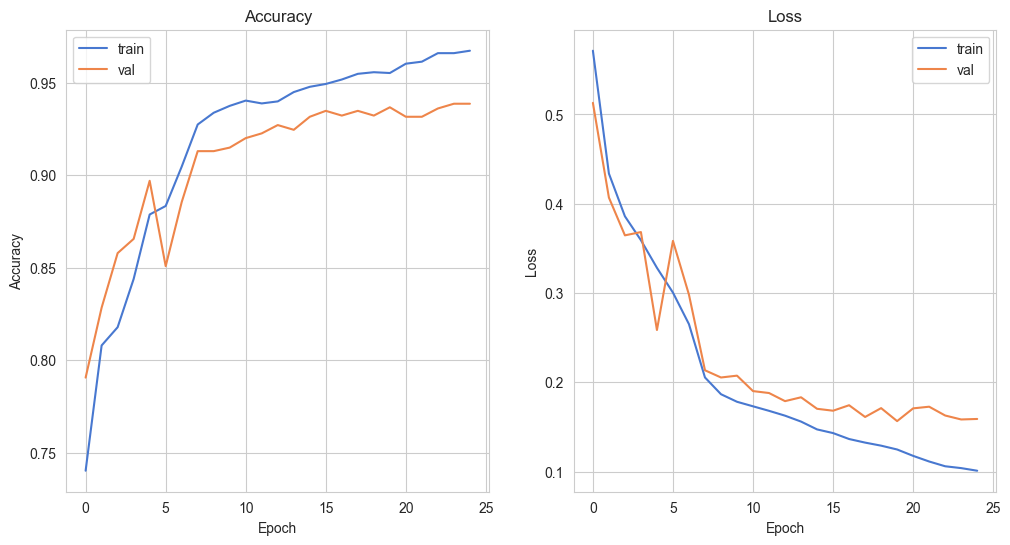

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# save the model
model.save("model.h5")

# Create Prediction

In [ ]:
import tensorflow as tf

In [ ]:
# load the model
model = tf.keras.models.load_model("model.h5")

In [ ]:
# create prediction to test data
text_sequences_test = tokenizer.texts_to_sequences(test_data.review_text)
text_sequences_test = pad_sequences(text_sequences_test, maxlen=max_length)


# the test data doens't have the target value, so we need to predict it
test_data["is_positive"] = model.predict(text_sequences_test)
test_data["is_positive"] = test_data["is_positive"].apply(lambda x: 1 if x >= 0.5 else 0)

test_data.head()

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 672ms/step


/tmp/ipykernel_4323/1529730287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["is_positive"] = model.predict(text_sequences_test)
/tmp/ipykernel_4323/1529730287.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["is_positive"] = test_data["is_positive"].apply(lambda x: 1 if x >= 0.5 else 0)


,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,is_positive
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id,1
18,Anis Suryandari,4,Alhamdullilah pelayanan di Puskesmas Simo bagu...,Puskesmas Simomulyo,alhamdulillah layan puskesmas simo bagus cepat...,id,1
19,Rindi Ariani,2,Puskesmas terlalu dekat dengan depo sampah bau...,Puskesmas Simomulyo,puskesmas depo sampah bau sengat udara panas b...,id,0
22,Della Anugrah Heni,3,berkunjung untuk penerbitan rujukan ke klinik ...,Puskesmas Simomulyo,kunjung terbit rujuk klinik mata akses mudah l...,id,1
27,Wahid Hasan,4,dokternya ramah²....\nAlhamdulillah sdh ada ke...,Puskesmas Simomulyo,dokter ramah alhamdulillah maju,ms,1
